Task 3:
- Use the data file "challenge 3.gwf" with channel "H1:CHALLENGE3"
- These are real LIGO data from O2, though we've adjusted the time labels and added some simulated signals.
- The data contain a loud simulated signal with m1 = m2 = 10 solar masses.
- What is the merger time of this signal?
- What is the matched-filter SNR of this signal?


In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
#Importing absolutely everything I could possibly need and a bit more so I don't have to do this again
! pip install -q 'gwosc==0.5.4'
! pip install -q 'gwpy==2.0.2'
! pip install lalsuite
! pip install PyCBC==1.18.0
import gwosc
from gwosc.datasets import find_datasets
from gwosc import datasets
from gwosc.datasets import event_gps
from gwosc.datasets import run_segment
from gwosc.locate import get_event_urls
import gwpy
from gwpy.timeseries import TimeSeries

%matplotlib inline

from pycbc.waveform import get_td_waveform
import pylab

import matplotlib.pyplot as pp
import pycbc.noise
import pycbc.psd

from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc import frame

from pycbc.filter import matched_filter
import numpy

Reason for being yanked: Metadata is broken
     |████████████████████████████████| 1.4 MB 28.1 MB/s 
     |████████████████████████████████| 51 kB 6.2 MB/s 
     |████████████████████████████████| 55 kB 3.5 MB/s 
     |████████████████████████████████| 3.6 MB 50.8 MB/s 
     |████████████████████████████████| 46.2 MB 1.6 MB/s 
     |████████████████████████████████| 1.4 MB 51.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 295 kB 49.9 MB/s 
  Created wheel for lscsoft-glue: filename=lscsoft_glue-3.0.1-cp37-cp37m-linux_x86_64.whl size=258417 sha256=a41e1ecb2d8436db9648d3d03521fa823a60081773856d86bedcf9a052bd87ab
  Stored in directory: /root/.cache/pip/wheels/62/ad/9a/6e89ceed9887a50c3c227beea125ad58f50b3622fbaf0873bf
Successfully built lscsoft-glue
     |████████████████████████████████| 6.3 MB 17.8 MB/s 
     |████████████████████████████████| 75 kB 4.1 MB/s 
 

With that out of the way, let's find the approximate merger time of the signal

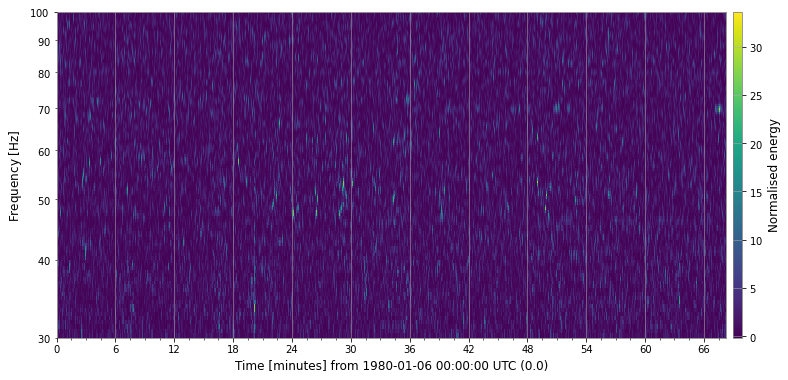

In [20]:
data = TimeSeries.read('/content/gdrive/My Drive/Google Colab/challenge3.gwf', 'H1:CHALLENGE3')

cq = data.q_transform(frange= (30,100), qrange=(100,110))
plot = cq.plot()
ax = plot.gca()
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

Nothing obvious yet, Let's clear things up a bit

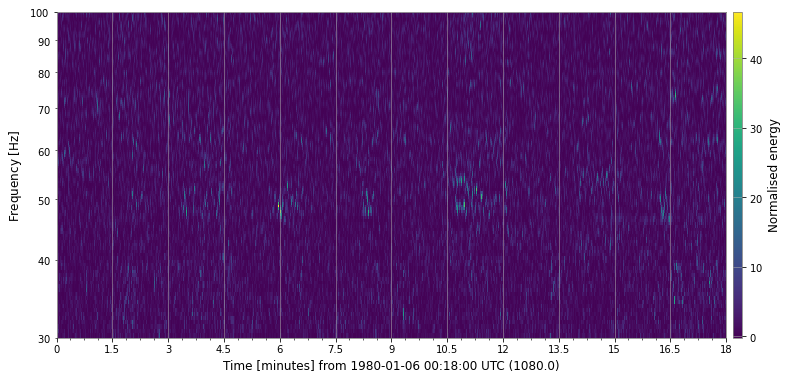

In [23]:
cq = data.q_transform(frange= (30,100), qrange=(100,110), outseg= (18*60, 36*60))
plot = cq.plot()
ax = plot.gca()
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

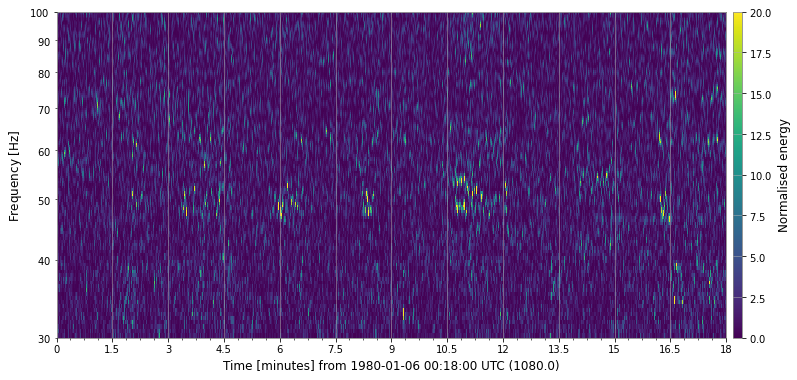

In [24]:
plot.colorbars[0].mappable.set_clim(0,20)
plot.refresh()
plot

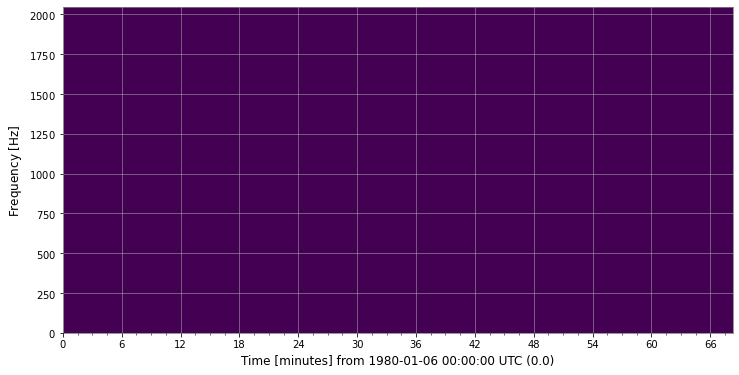

In [26]:
specgram = data.spectrogram2(fftlength= 4, overlap= 2, window= 'hann')**(1/2.)
plot = specgram.plot()

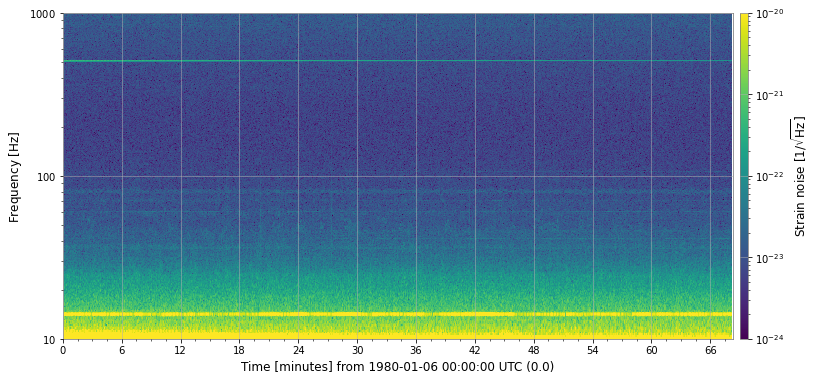

In [27]:
ax = plot.gca()
ax.set_yscale('log')
ax.set_ylim(10, 1000)
ax.colorbar(
    clim=(1e-24, 1e-20),
    norm="log",
    label=r"Strain noise [$1/\sqrt{\mathrm{Hz}}$]",
)
plot

I have no clue where the signal is supposed to be

Let's just find the match filtered SNR

No handles with labels found to put in legend.


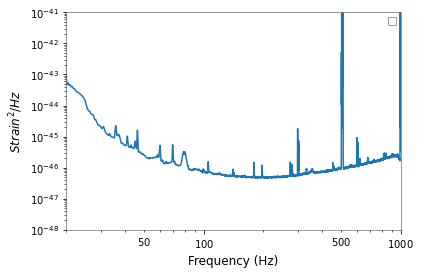

In [32]:
#Need to read the file again because apparently TimeSeries is different for gwpy and pyCBC
strain = frame.read_frame('/content/gdrive/My Drive/Google Colab/challenge3.gwf', 'H1:CHALLENGE3')

strain = highpass(strain, 20.0)
strain = resample_to_delta_t(strain, 1.0/2048)
conditioned = strain.crop(2,2)

psd = conditioned.psd(4)
psd = interpolate(psd, conditioned.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=20)



pylab.plot(psd.sample_frequencies, psd)

pylab.yscale('log')
pylab.xscale('log')
pylab.ylim(1e-48, 1e-41)
pylab.xlim(20, 1000)
pylab.ylabel('$Strain^2 / Hz$')
pylab.xlabel('Frequency (Hz)')
pylab.grid()
pylab.legend()
pylab.show()

In [33]:
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=10,
                     mass2=10,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

hp.resize(len(conditioned))
template = hp.cyclic_time_shift(hp.start_time)

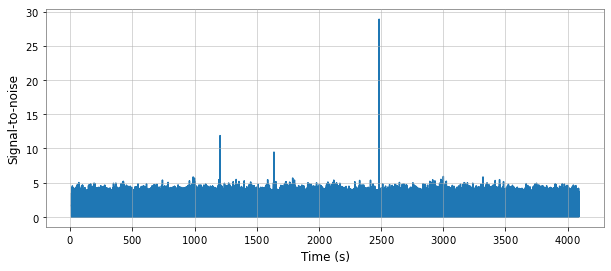

We found a signal at 2483.96728515625s with SNR 28.875814057421216


In [35]:
snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

snr = snr.crop(4 + 4, 4)

pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

With this knowledge, let's see if we can make the spectrogram make any sense (This isn't for the assignment, I just wanna know what on earth happened)

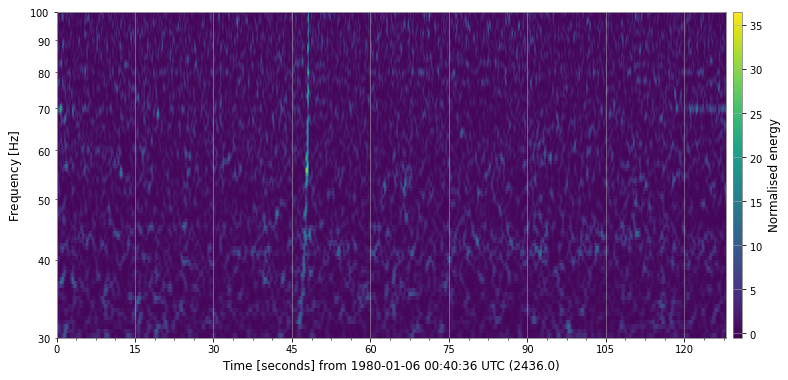

In [36]:
cq = data.q_transform(frange= (30,100), qrange=(100,110), outseg= (2436, 2564))
plot = cq.plot()
ax = plot.gca()
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

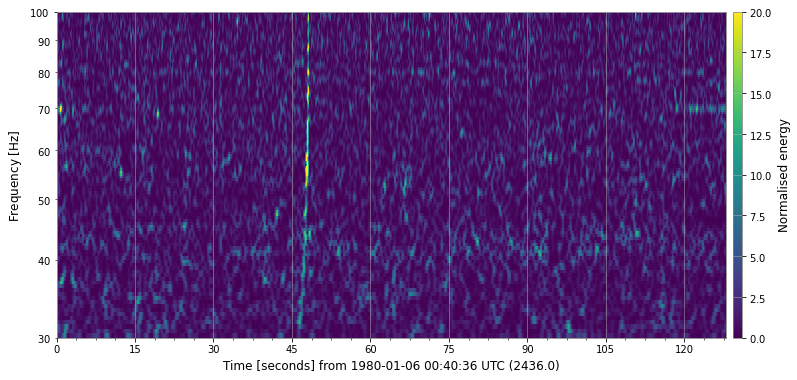

In [37]:
plot.colorbars[0].mappable.set_clim(0,20)
plot.refresh()
plot

Huh, there really is something there.

The merger time of the signal is at 2483.97s with SNR 28.87